<img src="assets/hpe_pri_grn_pos_rgb.png" alt="HPE Logo" width="200">


# PCAI Use Case Demo - License Plate Number Detection
## Step 1. Finetune License Plate Detection Model and Benchmark against various format.
Yolo object detection model does not include License Plate as an out of the box target. so we need to fine-tune the License Plate detection model separately.
But Ultralytics provides training capability, So we can simply fine-tune the baseline YOLO model. During Finetuning, For logging metrics and artifacts, we will leverage **MLflow**.</br></br>
After fine-tuning, we will explore several model serving format and benchmark them to decide the final format. 

### 0. Prerequisites
Followed [0. Introduction.ipynb](./0.Introduction.ipynb), ensure that you have run `pip install -r requirements.txt` in a Terminal window and execute `the cell to patch ultralytics` prior to running this notebook. 

### 1. Download Input Data

Download the License Plate Recognition Object Detection Dataset. ( https://universe.roboflow.com/roboflow-universe-projects/license-plate-recognition-rxg4e )

Then move to ./resources/datasets directory and update YOLO settings.

In [1]:
from ultralytics import settings
import os

settings.update({"datasets_dir": os.getcwd()})
print(settings["datasets_dir"])

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/geuntak/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
/mnt/user/LPD/materials


### 2. Fine-tuning the baseline model from YOLO
In this demo, we will leverage Ultralytics' one of the state-of-art model `YOLO11s` model.

In [2]:
from ultralytics import YOLO
import os

In [3]:
model = YOLO("yolo11s")
datasets = "./resources/datasets/data.yaml"

100%|██████████| 18.4M/18.4M [00:00<00:00, 166MB/s]


Add callback to update the AUTH_TOKEN in every model_save. Since AUTH_TOKEN in AIE notebook expires in 30 minutes. 

In [4]:
model.reset_callbacks()
def update_token(trainer):
    with open('/etc/secrets/ezua/.auth_token','r') as file:
        AUTH_TOKEN = file.read()
        os.environ['MLFLOW_TRACKING_TOKEN']=AUTH_TOKEN
        print("Token successfully refreshed.")

model.add_callback("on_model_save",update_token)
model.callbacks["on_model_save"]

[<function ultralytics.utils.callbacks.base.on_model_save(trainer)>,
 <function __main__.update_token(trainer)>]

Set the run_name to log and MLFLOW related environment variables.

In [5]:
run_name = model.model_name.name.replace('.pt','-') + time.strftime("%Y%m%d-%H%M%S", time.localtime())

os.environ['MLFLOW_RUN'] = run_name
os.environ['MLFLOW_TRACKING_URI'] = "https://mlflow.aie02.pcai.tryezmeral.com"
os.environ['MLFLOW_EXPERIMENT_NAME'] = 'license_plate_yolo11s'

In [6]:
import mlflow
print("MLflow Tracking URI:", mlflow.get_tracking_uri())

MLflow Tracking URI: http://mlflow.mlflow.svc.cluster.local:5000


Since it's demo, we just execute 3 epochs. it will take around 5 min in L40s. ( with T4, it will take around 15 min )</br>
*we can get better accuracy with more epochs*

In [7]:
results = model.train(data=datasets, epochs=3)  # train the model

New https://pypi.org/project/ultralytics/8.3.153 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.152 🚀 Python-3.11.9 torch-2.7.1+cu126 CUDA:0 (Tesla T4, 14918MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./resources/datasets/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=Fals

100%|██████████| 755k/755k [00:00<00:00, 17.9MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1    127680  ultralytics.nn.modules.block.C3k2            [512, 128, 1, False]          
 17                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 18            [-1, 13]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 19                  -1  1    345472  ultralytics.nn.modules.block.C3k2            [384, 256, 1, False]          
 20                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 22                  -1  1   1511424  ultralytics.nn.modules.block.C3k2            [768, 512, 1, True]           
 23        [16, 19, 22]  1    819795  ultralytics.nn.modules.head.Detect           [1, [

100%|██████████| 5.35M/5.35M [00:00<00:00, 76.6MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.1±0.1 ms, read: 14.9±8.4 MB/s, size: 43.7 KB)


train: Scanning /mnt/user/LPD/materials/resources/datasets/train/labels.cache... 21173 images, 28 backgrounds, 0 corrupt: 100%|██████████| 21173/21173 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 17.5±5.2 MB/s, size: 35.9 KB)


val: Scanning /mnt/user/LPD/materials/resources/datasets/valid/labels.cache... 2046 images, 3 backgrounds, 0 corrupt: 100%|██████████| 2046/2046 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)


2025/06/11 08:22:00 WARNING mlflow.utils.autologging_utils: MLflow statsmodels autologging is known to be compatible with 0.11.1 <= statsmodels <= 0.14.2, but the installed version is 0.14.4. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a compatible version, or try upgrading MLflow.
2025/06/11 08:22:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(79d2e92c492f4c7795a9759076c98480) to https://mlflow.aie02.pcai.tryezmeral.com
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         4G      1.328      1.235      1.326          9        640: 100%|██████████| 1324/1324 [06:06<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:19<00:00,  3.34it/s]

                   all       2046       2132      0.904      0.812      0.877      0.538


Token successfully refreshed.

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3      4.76G      1.265     0.7617      1.283          4        640: 100%|██████████| 1324/1324 [05:53<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:18<00:00,  3.46it/s]

                   all       2046       2132      0.934      0.896       0.94      0.593


Token successfully refreshed.

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3      4.76G      1.198     0.6601      1.238          7        640: 100%|██████████| 1324/1324 [05:48<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:18<00:00,  3.53it/s]

                   all       2046       2132      0.954      0.924      0.965      0.632


Token successfully refreshed.

3 epochs completed in 0.313 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 19.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.9 torch-2.7.1+cu126 CUDA:0 (Tesla T4, 14918MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:18<00:00,  3.39it/s]


                   all       2046       2132      0.954      0.924      0.963      0.632
Speed: 0.2ms preprocess, 4.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train


2025/06/11 08:41:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run yolo11s-20250611-082121 at: https://mlflow.aie02.pcai.tryezmeral.com/#/experiments/6/runs/79d2e92c492f4c7795a9759076c98480.
2025/06/11 08:41:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow.aie02.pcai.tryezmeral.com/#/experiments/6.


MLflow: results logged to https://mlflow.aie02.pcai.tryezmeral.com
MLflow: disable with 'yolo settings mlflow=False'


Save and Visualize training results

In [8]:
results.save_dir.joinpath("results.csv")

PosixPath('runs/detect/train/results.csv')

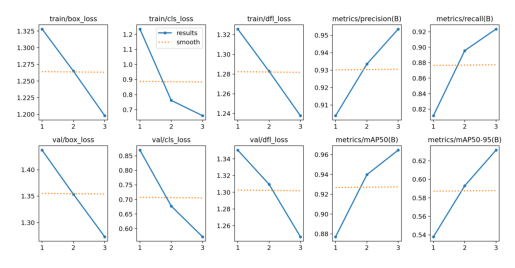

In [10]:
%matplotlib inline
import cv2 as cv
import matplotlib.pyplot as plt
from ultralytics.utils.plotting import plot_results

plot_results(results.save_dir.joinpath("results.csv")) # <-- Create results.png
results_png = plt.imread(results.save_dir.joinpath("results.png"))
plt.imshow(results_png)
plt.axis('off')
plt.show()

### 3. Test Model
model was trained to detect license plate only. So it must return the result of license plate detection

In [11]:
result_path = results.save_dir # runs/detect/train3/
model_path = results.save_dir.joinpath("weights/best.pt") # runs/detect/train3/weights/best.pt

In [12]:
license_detector = YOLO(results.save_dir.joinpath("weights/best.pt"))
license_detector.names.values()

dict_values(['License_Plate'])

In [13]:
license_results = license_detector("./resources/Samples/car_image.jpg",save=True)


image 1/1 /mnt/user/LPD/materials/resources/Samples/car_image.jpg: 640x640 1 License_Plate, 16.3ms
Speed: 2.6ms preprocess, 16.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


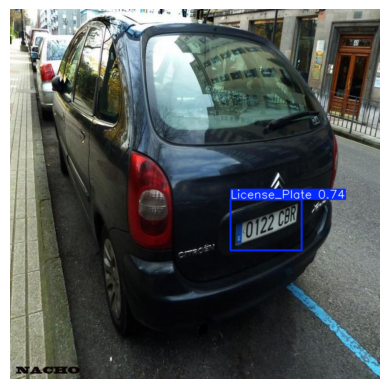

In [14]:
%matplotlib inline
rgb_img = cv.cvtColor(license_results[0].plot(), cv.COLOR_BGR2RGB)
plt.imshow(rgb_img)
plt.axis('off')
plt.show()

### 4. Benchmark the model format for serving
There are several model formats with various serving performance. So we will do benchmark and find the most performant model format.</br>
During demo, if kernel daed accidently, change `model_path` from pathlib object to path string.

In [15]:
from ultralytics.utils.benchmarks import benchmark
import pandas as pd

In [16]:
datasets = "./resources/datasets/data.yaml"
model_path = results.save_dir.joinpath("weights/best.pt")

test_formats = ['-','torchscript','onnx','engine']

In [17]:
all_result = pd.DataFrame(columns=['Format','Status❔', 'Size (MB)', 'metrics/mAP50-95(B)', 'Inference time (ms/im)', 'FPS'])

for format in test_formats:
    result = benchmark(model=model_path, data=datasets, device=0,format=format)
    half_result = benchmark(model=model_path, data=datasets, device=0,format=format,half=True)
    half_result['Format'] = half_result['Format'] + '_half'
    
    all_result = pd.concat([all_result,result],ignore_index=True)
    all_result = pd.concat([all_result,half_result],ignore_index=True)

Setup complete ✅ (96 CPUs, 353.7 GB RAM, 211.9/999.8 GB disk)

Benchmarks complete for runs/detect/train/weights/best.pt on ./resources/datasets/data.yaml at imgsz=160 (340.11s)
Benchmarks legend:  - ✅ Success  - ❎ Export passed but validation failed  - ❌️ Export failed
     Format Status❔  Size (MB)  metrics/mAP50-95(B)  Inference time (ms/im)     FPS
0  TensorRT       ✅       20.9               0.3917                    2.32  430.04



### 5. Choose the Model serving format based on Benchmark Results
1. TensorRT engine with Half precision is the best for FPS. ( Over 5 times faster than PyTorch format )
2. mAP50-95 score is also almost preserved even though the Model file was converted various types.
3. For model format, Choose TensorRT Engine & Half Precision
4. **Since Triton Inference Server supports TensorRT backend out of the box, decided to leverage it.**

In [18]:
all_result

,Format,Status❔,Size (MB),metrics/mAP50-95(B),Inference time (ms/im),FPS
0,PyTorch,✅,18.3,0.4049,12.51,79.90
1,PyTorch_half,✅,18.3,0.4051,14.02,71.30
2,TorchScript,✅,36.4,0.3922,6.02,165.99
3,TorchScript_half,✅,36.4,0.3915,6.52,153.32
4,ONNX,✅,36.0,0.3922,4.42,226.40
5,ONNX_half,✅,18.0,0.3918,5.80,172.24
6,TensorRT,✅,37.9,0.3922,3.00,333.25
7,TensorRT_half,✅,20.9,0.3917,2.32,430.04


### 6. Convert yolo model to TensorRT Engine
#### *Before Directly Convert model with YOLO API, Please check below patch is applied*
- Block some lines in ultralytics/engine/exporter.py to prevent well known issue with Triton Inference Server ( https://github.com/ultralytics/ultralytics/issues/4597#issuecomment-1694948850 )
- *Make sure below snippet is blocked in your environment. if you patch followed [0.Introduction.ipynb](./0.Introduction.ipynb), then it's already patched.*

```bash
    (base) geuntak@license-detector-0:~/.local/lib/python3.11/site-packages/ultralytics/engine$ diff exporter.py exporter.py_org 
    962,965c962,965
    < #            # Metadata
    < #            meta = json.dumps(self.metadata)
    < #            t.write(len(meta).to_bytes(4, byteorder="little", signed=True))
    < #            t.write(meta.encode())
    ---
    >             # Metadata
    >             meta = json.dumps(self.metadata)
    >             t.write(len(meta).to_bytes(4, byteorder="little", signed=True))
    >             t.write(meta.encode())
```

#### check the output shape
YOLO model's raw output dimension is **[ batch size, ( # of target object + bounding box x1,y1,x2,y2 ) , potential detection locations ]**</br></br>
**License Detector**
- 1 : batch size
- 5 : license plate + ( x1, x2, h1, w1 )
- 8400 : potential detection locations

**vehicle Detector (yolo11s)**
- 1 : batch size
- 84 : 80 + ( x1, x2, h1, w1 )
- 8400 : potential detection locations

In [19]:
from ultralytics import YOLO
import torch

license_detector = YOLO(model_path)
vehicle_detector = YOLO("yolo11s")
license_detector.eval()
vehicle_detector.eval()

target_models = {
    "license_detector":license_detector,
    "vehicle_detector":vehicle_detector
}

dummy_input = torch.randn(1, 3, 640, 640)

for name, model in target_models.items():
    with torch.no_grad():
        outputs = model.model(dummy_input)

    for out in outputs:
        # Some outputs are lists; checking each element carefully
        if isinstance(out, torch.Tensor):
            print(f"{name} - Input Shape : {out.shape}")

license_detector - Input Shape : torch.Size([1, 5, 8400])
vehicle_detector - Input Shape : torch.Size([1, 84, 8400])


Convert license detection model. It requires NVIDIA gpu. it will take around 3 ~ 5 min with T4

In [20]:
# Retrieve metadata during export. Metadata needs to be added to config.pbtxt. See next section.
metadata_license = []

def export_cb_for_license(exporter):
    metadata_license.append(exporter.metadata)
    
license_detector.add_callback("on_export_end", export_cb_for_license)

# Export the model
license_detector_engine = license_detector.export(format="engine", dynamic=True,half=True,device=0)

# change Dimensions properly
data = """
# Add metadata
parameters {
  key: "metadata"
  value {
    string_value: "%s"
  }
}

name: "license_detector"
platform: "tensorrt_plan"
max_batch_size : 0
input [
  {
    name: "images"
    dims: [ -1, 3, -1, -1 ]
  }
]
output [
  {
    name: "output0"
    dims: [ -1, 5, 8400 ]
  }
]
""" % metadata_license[0]


with open("config-license.pbtxt", "w") as f:
    f.write(data)

Ultralytics 8.3.152 🚀 Python-3.11.9 torch-2.7.1+cu126 CUDA:0 (Tesla T4, 14918MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (18.3 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.56...
ONNX: export success ✅ 8.2s, saved as 'runs/detect/train/weights/best.onnx' (36.1 MB)

TensorRT: starting export with TensorRT 10.8.0.43...
[06/11/2025-08:54:04] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU -1138, GPU +180, now: CPU 6001, GPU 1120 (MiB)
[06/11/2025-08:54:05] [TRT] [I] ----------------------------------------------------------------
[06/11/2025-08:54:05] [TRT] [I] Input filename:   runs/detect/train/weights/best.onnx
[06/11/2025-08:54:05] [TRT] [I] ONNX IR version:  0.0.9
[06/11/2025-08:54:05] [TRT] [I] Opset version:    19
[06/11/2025-08:54:05] [TRT] [I] Producer

Convert vehicle detection model. It requires NVIDIA gpu. it will take around 3 ~ 5 min with T4

In [21]:
metadata_vehicle = []

def export_cb_for_vehicle(exporter):
    metadata_vehicle.append(exporter.metadata)
    
vehicle_detector.add_callback("on_export_end", export_cb_for_vehicle)

# Export the model
vehicle_detector_engine = vehicle_detector.export(format="engine", dynamic=True,half=True,device=0)

# change Dimensions properly
data = """
# Add metadata
parameters {
  key: "metadata"
  value {
    string_value: "%s"
  }
}

name: "vehicle_detector"
platform: "tensorrt_plan"
max_batch_size : 0
input [
  {
    name: "images"
    dims: [ -1, 3, -1, -1 ]
  }
]
output [
  {
    name: "output0"
    dims: [ -1, 84, 8400 ]
  }
]
""" % metadata_vehicle[0]

with open("config-vehicle.pbtxt", "w") as f:
    f.write(data)

Ultralytics 8.3.152 🚀 Python-3.11.9 torch-2.7.1+cu126 CUDA:0 (Tesla T4, 14918MiB)
YOLO11s summary (fused): 100 layers, 9,443,760 parameters, 0 gradients, 21.5 GFLOPs

PyTorch: starting from 'yolo11s.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (18.4 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.56...
ONNX: export success ✅ 6.8s, saved as 'yolo11s.onnx' (36.2 MB)

TensorRT: starting export with TensorRT 10.8.0.43...
[06/11/2025-08:57:48] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU -1041, GPU +176, now: CPU 5927, GPU 1122 (MiB)
[06/11/2025-08:57:48] [TRT] [I] ----------------------------------------------------------------
[06/11/2025-08:57:48] [TRT] [I] Input filename:   yolo11s.onnx
[06/11/2025-08:57:48] [TRT] [I] ONNX IR version:  0.0.9
[06/11/2025-08:57:48] [TRT] [I] Opset version:    19
[06/11/2025-08:57:48] [TRT] [I] Producer name:    pytorch
[06/11/2025-08:57:48] [TRT] [I] Producer version: 

### 7. Create Triton compatible Directory
In order to use triton server, we need to comply the model directory format and filename.</br>
**Triton model repository layout**<br> Refer : https://docs.nvidia.com/deeplearning/triton-inference-server/user-guide/docs/user_guide/model_repository.html#repository-layout 
```bash
  <model-repository-path>/
    <model-name>/
      [config.pbtxt]
      [<output-labels-file> ...]
      [configs]/
        [<custom-config-file> ...]
      <version>/
        <model-definition-file>
```

In [22]:
from pathlib import Path
import shutil
import os

In [23]:
base = Path("triton_engines")
    
# Model configurations
models = [
    ("license_detector", "config-license.pbtxt", license_detector_engine, 1),
    ("vehicle_detector", "config-vehicle.pbtxt", vehicle_detector_engine, 1)
]

for model_name, config_file, engine_file,version in models:
    # Create directory structure
    model_dir = base / model_name
    version_dir = model_dir / str(version)
    version_dir.mkdir(parents=True, exist_ok=True)
    
    # Move files
    shutil.move(config_file, model_dir / "config.pbtxt")
    shutil.move(engine_file, version_dir / "model.plan")

def display_tree(directory, prefix="", is_last=True):
    """Display directory tree using pathlib"""
    directory = Path(directory)
    print(prefix + ("└── " if is_last else "├── ") + directory.name)
    
    if directory.is_dir():
        children = sorted(directory.iterdir())
        for i, child in enumerate(children):
            is_last_child = i == len(children) - 1
            new_prefix = prefix + ("    " if is_last else "│   ")
            display_tree(child, new_prefix, is_last_child)

path = Path("triton_engines")
display_tree(path)

└── triton_engines
    ├── license_detector
    │   ├── 1
    │   │   └── model.plan
    │   └── config.pbtxt
    └── vehicle_detector
        ├── 1
        │   └── model.plan
        └── config.pbtxt


### 8. Upload Model Artifacts into the MLflow.

In this part, we will use example files in triton inference server github repo. <br>
**Ref** : https://github.com/triton-inference-server/server/tree/main/deploy/mlflow-triton-plugin#triton-flavor

In [24]:
%update_token

Token successfully refreshed.


In [25]:
import os
os.environ['MLFLOW_TRACKING_URI'] = "https://mlflow.aie02.pcai.tryezmeral.com"

In [27]:
!python resources/mlflow_scripts/publish_model_to_mlflow.py --model_name license-detector --model_directory ./triton_engines --flavor triton

/home/geuntak/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.aie02.pcai.tryezmeral.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/geuntak/.local/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.aie02.pcai.tryezmeral.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
<module 'triton_flavor' from '/mnt/user/LPD/materials/resources/mlflow_scripts/triton_flavor.py'>
2025/06/11 09:08:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/home/geuntak/.local/lib/pytho

<img src="assets/mlflow_bucket_example.png" alt="mlflow_bucket_example">
